# Lesson 2 Homework - Training the VGG model

After taking a look at the linear model that was created at the beginning of Lesson 2, I now need to go through the exercise of reusing the VGG model and tayloring it to our `Cats vs. Dogs` competition (i.e. coming up with 2 category predictions for those images, rather than having a 1,000 categories).

__Note :__ this notebook was written with Keras 1.2.2. (I know...)

## Prepping directories and batches

In [1]:
import os, sys
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
#Allow relative imports to directories above lesson1/
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# Rather than importing everything manually, we'll make things easy
#   and load them all in utils.py, and just import them from there.
%matplotlib inline
import utils; reload(utils)
from utils import *

Using Theano backend.


ImportError: No module named vgg16bn

In [2]:
import numpy as np
import keras
from keras.models import Sequential
from matplotlib import pyplot as plt

I added a couple of `if` statements below to avoid issues when restarting the Kernel and running all the cells. This makes it easier to test / debug as you can restart from scratch at any point.

In [3]:
DATA_HOME_DIR = current_dir+'/data/dogscats/'
path = DATA_HOME_DIR
model_path = path + 'models/'
valid_path = path + 'valid/'
train_path = path + 'train/'

# We check to see if the models directory exists or not
if not os.path.exists(model_path): os.mkdir(model_path)

# We check to see if the validation set has been created
# before we run through and move the files from the train
# directory. More specifically we just check for the existence
# of the "valid" directory
if not os.path.exists(valid_path):
    os.mkdir(valid_path)
    %cd $train_path
    g = glob('*.jpg')
    shuf = np.random.permutation(g)
    for i in range(2000): os.rename(shuf[i], valid_path + shuf[i])

In [4]:
# For each set, we split the images in their respective categories,
# i.e. directories -- unless the directories already exist
# This could of course be improved but that works for my purpose.
for loop_path in [train_path,valid_path]:
    %cd $loop_path
    if not(os.path.exists(loop_path + 'cats/') and os.path.exists(loop_path + 'dogs/')) :
        %mkdir cats
        %mkdir dogs
        %mv cat.*.jpg cats/
        %mv dog.*.jpg dogs/

/Users/nicolasphilippe/Documents/GitHub/courses/deeplearning1/nbs/lesson2/data/dogscats/train
/Users/nicolasphilippe/Documents/GitHub/courses/deeplearning1/nbs/lesson2/data/dogscats/valid


## Batch works... no need loading those 23k images in memory !

Now that we've properly setup the data in the different directories, we need to get a training batch and a validation batch. This is done by using the `get_batches` function located in the `vgg1.py` file. It's really just a wrapper for the [`ImageDataGenerator()`](https://keras.io/preprocessing/image/), most specifically the `flow_from_directory` function.

Because the default value for `class_mode` is `categorical` the generator knows how to assign categories to those images based on the directories available (i.e. cats and dogs).

__Note : this notebook only uses batches rather than importing all the images, as is done in the Lesson 2 video and Notebook. The reason for this is the duplication of effort and the HUGE amount of memory occupied by importing the images in memory (up to 28Gb in RAM/swap on my laptop !).__ I honestly had a hard time understanding why we bothered with `get_data()` in the first place anyway -- though the exercise was interesting.

There are [several issues reported](http://forums.fast.ai/t/get-data-function-running-out-of-memory-on-training-data-in-lesson-2/435) in the Lesson2 forum, about running out of memory. You can also see Jeremy's [suggestion](http://forums.fast.ai/t/lesson-2-discussion/161/58) around using `fit_generator`. But this *wasn't the approach I wanted to take*. Rather I used `predict_generator` to still show the intermediate predictions obtained from VGG. But I am getting ahead of myself...

In [5]:
# Get validation set -- I always do the smaller one first in case
# I need to debug a problem. Batch size of 40 was about right for my
# Macbook Pro, i.e. it didn't need to embarrassingly swap 16Gb of RAM
# to disk ! 
batch_size=40
val_batch = get_batches(valid_path, shuffle=False, batch_size=batch_size)
print(val_batch.class_indices)

Found 2000 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}


Now let's take a look at a couple of images from our validation set to make sure all is well...

(40, 3, 224, 224)


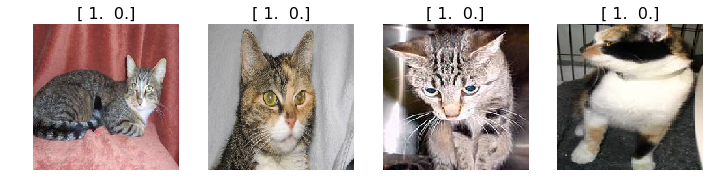

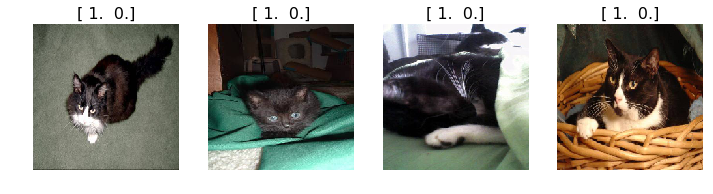

In [6]:
# Since the batch size is defined as `20`
# we're only showing the first 4 images.
imgs,labels = next(val_batch)
plots(imgs[:4], titles=labels[:4])
print(imgs.shape)
# Let's get the next set of (20) images
# and only show the first 4 of that next set.
imgs,labels = next(val_batch)
plots(imgs[:4], titles=labels[:4])

__Note :__ when calling on the next batch, as we're doing above, you always need to make sure to reset the generator when you need to work on the entire dataset (like training the model). Otherwise you'll end up with less data, since you've already iterated over a few samples.

And now on to the training set... The same display of images and shape can be done for the training set, but we'll save some time (and space) here and just move on.

In [7]:
train_batches = get_batches(train_path, shuffle=False, batch_size=1)
train_batches.class_indices

Found 23000 images belonging to 2 classes.


{'cats': 0, 'dogs': 1}

### One hot encoding of labels

Now while I understand the need for the one-hot encoding of the labels, I am not quite sure why Jeremy chose to define his own function since Keras' np_utils already provides that. Maybe they wanted to clearly explain how this is done and get people curious ? Meh... Might want to check [Rachel's comment](http://forums.fast.ai/t/lesson-2-discussion/161/51) on this.

In [8]:
val_labels = np_utils.to_categorical(val_batch.classes)
print(val_labels)
val_labels.shape

[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]


(2000, 2)

In [9]:
trn_labels = np_utils.to_categorical(train_batches.classes)
print(trn_labels)
trn_labels.shape

[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]


(23000, 2)

For both sets we can see that we have a matrix of `2000x2` and `23000x2` respectively : i.e. `cats` and `dogs`, which make up the 2 lable "columns" for each picture.

So now that we have the labels for both the training and validation sets, we'll need to move on to defining the model that we'll want to use and refine for our particular case.

## Reusing the Vgg model

Since we're training on images taken from the ImageNet competition it makes sense to reuse the VGG model, which won the competition a few years back, as Jeremy pointed out.

In [10]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

### Input predictions

So, based on the selected model (VGG16) and its summary, we can tell that the result of the last layer (`Dense`) is a vector `1,000`-element long. This fits nicely with the intended purpose to classify images in one thousand categories for the ImageNet challenge.

But what about those "predictions" mentioned in Lesson 2 ? Well, I didn't quite understand what `model.predict()` did until I started looking at the shape of the results and the results themselves.

In [11]:
# Let's reset the batch iterator since we looked at
# some of them when we displayed the images
val_batch.reset()

# Files to save the validation and training predictions (features)
val_featfile = model_path + 'valid_lastlayer_features.bc'
trn_featfile = model_path+ 'train_lastlayer_features.bc'

# Let's first get the validation set predictions via predict_generator()
# or simply by loading them from file if they were already saved.
val_features = load_array(val_featfile) if os.path.exists(val_featfile) else model.predict_generator(val_batch, 2000)
print(val_features.shape)

# Finally let's save the predictions for the validation set
# so we don't have to compute them again.
save_array(val_featfile,val_features)

(2000, 1000)


In [12]:
print(val_features[:5])

[[  9.2654e-07   8.9023e-06   2.1081e-06 ...,   6.6987e-06   4.3053e-05   4.1940e-04]
 [  1.0024e-06   1.4794e-06   4.0552e-07 ...,   2.2765e-07   1.7920e-04   2.2112e-04]
 [  7.4928e-08   2.6982e-06   1.7980e-07 ...,   9.1045e-06   9.9019e-05   1.1664e-04]
 [  6.3711e-07   1.4918e-07   1.5500e-07 ...,   7.7987e-07   5.1317e-05   1.6215e-03]
 [  8.2654e-09   4.9856e-07   1.1304e-07 ...,   1.2094e-08   1.4839e-05   2.5672e-05]]


So the prediction on the validation set returns a `2000x1000` matrix. If we look at the values in this matrix it helps to understand what those values are : for each image (`2000` of them) there's a prediction given that this image belongs to a particular category.

Let's verify this "hypothesis" though, just to make sure.

In [13]:
val_featurepred_nothot = np.argmax(val_features, axis=1)
print(val_featurepred_nothot[0])
val_featurepred_nothot

281


array([281, 281, 281, ..., 234, 208, 219])

For example, the first image in the set belongs to category `281`. Since we don't have the exact category labels from the original ImageNet that was used to train the VGG model, it's difficult to say for sure what this corresponds to. However, there are some [resources online](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) showing that this index might correspond to

    281: 'tabby, tabby cat',

Ok, well I am not a cat-expert, but the first image is definitely a cat. Similarly for the last indices :

     208: 'Labrador retriever',
     ...
     219: 'cocker spaniel, English cocker spaniel, cocker',
     ...
     234: 'Rottweiler'
     
Therefore, using a *very* rough check on the category indices and what I found online, we can confirm (or at least be comforted in the illusion !) that those few first and last predictions belong to cats and dogs. Good !

Now on to computing those predictions for the training set.

In [14]:
trn_features = load_array(trn_featfile) if os.path.exists(trn_featfile) else model.predict_generator(val_batch, 23000)
print(trn_features.shape)

(23000, 1000)


In [15]:
print(trn_features[:5])

[[  4.2062e-07   1.5420e-03   6.3156e-06 ...,   3.2240e-07   3.9332e-05   7.6541e-02]
 [  2.1053e-06   5.4372e-06   1.6826e-06 ...,   5.9714e-07   4.3381e-05   3.7110e-04]
 [  9.0094e-07   1.0360e-05   3.8705e-07 ...,   1.5642e-06   2.9683e-04   6.4369e-05]
 [  1.1949e-07   9.4443e-05   7.3415e-07 ...,   2.6432e-07   1.4821e-04   6.0339e-03]
 [  1.4679e-07   9.1069e-07   1.5109e-06 ...,   4.0215e-08   1.0320e-04   6.4380e-04]]


In [16]:
save_array(trn_featfile,trn_features)

#### Applying the VGG predictions to our linear model

Now that we have the predictions from VGG on both our training and validation sets, we can use those as inputs to a linear model similar to the one presented at the beginning of Lesson 2.

The idea that we could use the predictions as input to a Dense layer took some time to sink in for me -- not sure it's even cured properly yet ! But once I *admitted* that, the next steps were pretty straightforward. We're essentially just teaching this single-layer-model how to shrink all those different sub-categories into CATS and DOGS.

In [17]:
# 1000 inputs, since that's the saved features, and 2 outputs, for dog and cat
lm = Sequential([ Dense(2, activation='softmax', input_shape=(1000,)) ])
lm.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
lm.evaluate(val_features, val_labels, verbose=1)

  32/2000 [..............................] - ETA: 0s

[0.68882568264007571, 0.61899999999999999]

This first call to `evaluate()` gives us a pretty good perspective on how unfit (pun-intended) the model is currently. It's really supposed to show something close to `[0,1]` in order to match our current [cat,dog] categorization. But right now we are nowhere close. Yikes !

So we'll need to __fit__ our model by passing it the training predictions / training labels set and the validation predictions / validation labels set.

In [19]:
lm.fit(trn_features, trn_labels, nb_epoch=3, batch_size=batch_size, 
       validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/3
23000/23000 [==============================] - 0s - loss: 0.0951 - acc: 0.9679 - val_loss: 0.0883 - val_acc: 0.9705
Epoch 2/3
23000/23000 [==============================] - 0s - loss: 0.0873 - acc: 0.9747 - val_loss: 0.0984 - val_acc: 0.9725
Epoch 3/3
23000/23000 [==============================] - 0s - loss: 0.0875 - acc: 0.9773 - val_loss: 0.1005 - val_acc: 0.9695


Alrighty... So now that we seem to be a little happier based on the loss value of the validation set, let's take another look at the `evaluate()` call :

In [20]:
lm.evaluate(val_features, val_labels, verbose=1)

  32/2000 [..............................] - ETA: 0s

[0.10054876443941611, 0.96950000000000003]

In [21]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_4 (Dense)                  (None, 2)             2002        dense_input_1[0][0]              
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
____________________________________________________________________________________________________


Somewhat better ! By training the model again and again it might be possible to get even closer to zero and one, but for now let's just be contempt with ourselves.

## Conclusion

For now this is it for this homework assignment of Lesson 2. I might however come back to the last part of the lesson (pop-ing the last `Dense` layer of VGG) at a later time but that part seemed pretty straightforward compared to the one we just went through.

Just remember that I modified the original Lesson 2 Notebook code to use `predict_generator` instead of relying on the loading of all images in memory (again, I didn't understand the duplication of effort). Based on your version of Keras you might need to modify the syntax as it has changed in newer versions.

As an example, this is what memory looked like with the original notebook (32GB with 20GB of swap) :
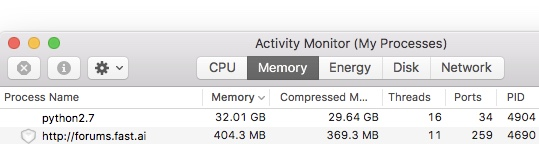

But when using batches of 40 pictures I only noticed peaks of 2.6GB with a very honest (235MB) swap size.

So, while it might be possible to increase the number of samples in each batch to speed things up, this solution will eventually compute the training and validation set predictions without running out of memory or going through an unbearable amount of disk swapping.